In [1]:
#%pip install networkx
#%pip install lightgbm

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import math
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import operator
from operator import itemgetter
import matplotlib.ticker as tick
import statsmodels.api as sm
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
import itertools

## Link Prediction UTS @ Kaggle

This project takes a Link Prediction UTS dataset of Facebook Competition Emails on [Link Prediction UTS on kaggle - Predict the links occurring in next time step_, kaggle](https://www.kaggle.com/c/link-prediction-uts/overview). 

Link prediction is a thoroughly studied yet challenging task in Network science. You can find an introduction to link prediction and several methods for solving link prediction at [Wikipedia -- Link prediction](https://en.wikipedia.org/wiki/Link_prediction) and [Link Predictions in Large Scale Networks, Gulliaume Le Floch](https://hackernoon.com/link-prediction-in-large-scale-networks-f836fcb05c88).

The notebook comprises a brief problem description, Exploratory Data Analysis (EDA), analysis in model building and training, results, discussion and conclusion.

### 1. Brief Problem Description - Link Prediction Problem
Social networks are very dynamic because associations among members within a community at any given time are added in the form of new edges and vertices to the existing network or graph over time. Each vertex corresponds to a member in the community and each edge represents some form of association between the corresponding pair of members.

A typical question to ask is what new associations among members in this community will be most likely formed next at next time epoch? Formally, Link Prediction problem asks if given a network at time $t$, can we predict which edges will be most likely formed at next time step $t+1$?

From an operational perspective, a link prediction problem tries to predict the likelihood of a future association between two nodes, knowing that there is no association between the nodes in the current state of the graph. Namely, link prediction algorithms aim at estimating the tendency of the existence of a link between two nodes, based on observed links, attributes of nodes, or through dynamic correlations.

A link prediction problem has a suite of applications. One application example is in area of bioinformatics. A link prediction problem can be applied to research interactions between proteins. Our knowledge on biological networks can be limited. For example, most of the molecular interactions in cells are still unknown. Using link prediction results to guide the laboratorial experiments, rather than blindly checking all possible interactions, can greatly reduce many experimental costs. Other application examples can also be found in e-commerce, friendly suggestions by online social media, and understanding the evolving co-authorship network in academics.

## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Description
### 2.2 Exploratory Data Analysis (EDA)
### 2.3 Concepts and Measures to Predict New Links
#### 2.3.1 Computing Adjusted-Rand Index of node 𝑢 and 𝑣, ARI(𝑢,𝑣)
### 2.4 Find Removable Links from Connected Node Pairs to Simulate Positive Samples
### 2.5 Split Dataset to Simulate Community Connections Growing Process


### 2.1 Data Description

The dataset can be found at [Link Prediction UTS on kaggle - Predict the links occurring in next time step_, kaggle](https://www.kaggle.com/c/link-prediction-uts/overview). The goal in the kaggle competition is to predict which edges (a.k.a. links) will appear in the next time step. The dataset consists of $999$ nodes and $117,031$ edges a submission requires a list of all possible edges with a label for whether the edge is "active". If there is an edge exists in the graph, we say it is 'active', indicated by a 1 in the data. If the edge does not exist in the graph, we call it 'inactive', this is indicated by a 0 in the data. You can also relate these data points with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people. For simplication, we will analyze the dataset as an undirected graph, and the target varialbe would be binary to indicate the presence of links or not.

The dataset comprises four data fields ($edge\_id$, $active$, $u$, and $v$), $499,500$ records, $999$ unique vertices, and $117,031$ edges.

In [3]:
connections = pd.read_csv('edges.csv')
print("Data Sizes: ", connections.shape[0])
print("Data Columns: ", connections.columns.tolist())
print("# of Unique Vertices: ",connections["u"].value_counts().shape[0])

data_edges = connections[connections["active"]==1]
print("# of Unique Edges: ",data_edges.shape[0])

Data Sizes:  499500
Data Columns:  ['edge_id', 'active', 'u', 'v']
# of Unique Vertices:  999
# of Unique Edges:  117031


### 2.2 Exploratory Data Analysis (EDA)
The EDA step comprises four parts to visualize and understand the complex connections among users in the community.

The first step is to use graph/network to summarize all the connections defined in the dataset.
Second Step is to historgram to plot and understand the distribution of degree sizes for the nodes in the network. The third step visualizes several special types of networks to attemt to reveal and/or understand the complexity of connections among users in the community.

Lastly, as part of preliminary analysis and feature engineering to facilitate model building and training for Supervised Learning, a suite of similarities metrics will be computed and charted to understand their value to help solve the link predict problem.   

In [4]:
# Step 1: Use networkX to define graph/network

GraphType = nx.Graph()
G = nx.from_pandas_edgelist(data_edges, source='u',
                            target='v', create_using=GraphType)

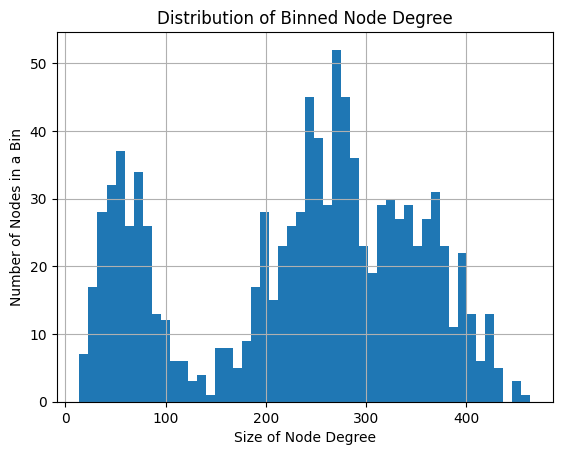

In [5]:
# Step 2: Use historgram to plot and understand
# the distribution of degree sizesover nodes

node_colors = [G.degree(v) for v in G]
node_sizes = [G.degree(v) for v in G]

#print("node sizes = ", node_sizes)
pd.DataFrame(node_sizes).hist(bins=50)

# Add title and axis names
plt.title('Distribution of Binned Node Degree')
plt.xlabel('Size of Node Degree')
plt.ylabel('Number of Nodes in a Bin')
pyplot.show()

The histogram shows two separate distributions: one has connections lower than 150 users with its mode  at around 60 users, and the other has connections more than 150 users with its mode around 270 users. The second distribution seems to be a combination of another two distributions comprising somewhat more connected users in the community with the threshold connections at 300 users.

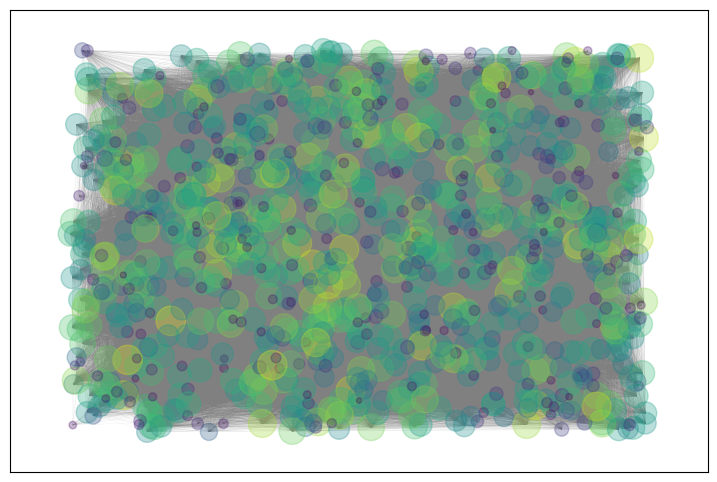

In [6]:
# Step 3: Visualize Networks: Entire Network

plt.figure(figsize=(9,6))
pos = nx.random_layout(G)
#node_sizes = [G.degree(v) for v in G]
nx.draw_networkx(G, pos, node_size = node_sizes,
                 node_color = node_colors, with_labels=False,
                 edge_color='gray',  alpha=0.3, width=0.1)

This entire network does not show much information other than the nodes/users with much more connections (in larger and color circles) than other users (smaller circles and gray area). We will turn to look at one specific sub-network, ego graph.

Largest Hub Node = 611 with degree of 464


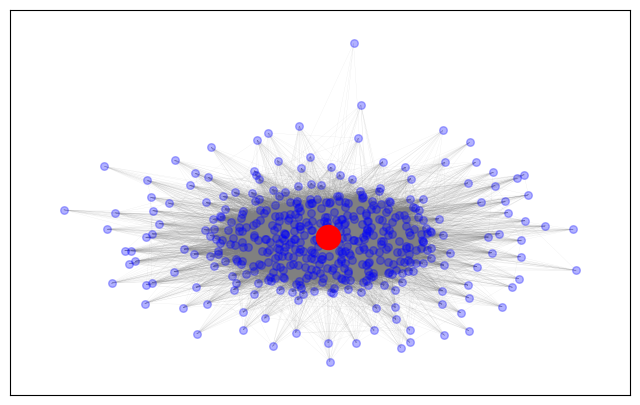

In [7]:
node_and_degree=G.degree()
(largest_hub, degree) = sorted(node_and_degree,
                               key=itemgetter(1))[-1]
print('Largest Hub Node = {} with degree of {}'.format(largest_hub,
                                                       degree))

# Create ego graph of main hub
hub_ego=nx.ego_graph(G,largest_hub)

# Draw graph
plt.figure(figsize=(8,5))
pos = nx.spring_layout(hub_ego)

nx.draw_networkx(hub_ego, pos, node_color="b", node_size=30,
                 edge_color='gray', alpha=0.3, width=0.1,
                 with_labels=False
                )
# Draw ego as large and red
options = {"node_size": 300, "node_color": "r",
           "label": str(largest_hub)}
nx.draw_networkx_nodes(hub_ego, pos, 
                       nodelist=[largest_hub], **options)

#plt.savefig('ego_graph.png')
plt.show()

This network shown above is an illustration of ego network of the node $611$ connected with $464$ other users, the largest numbero connected users. As indicated in the article [Ego graph Using Networkx in Python](https://www.geeksforgeeks.org/ego-graph-using-networkx-in-python/), ego network conprises one central node and all other nodes directly connected to it, and is mostly used in analyzing social connections and relationships.

Largest Hub Node = 98 with degree of 256


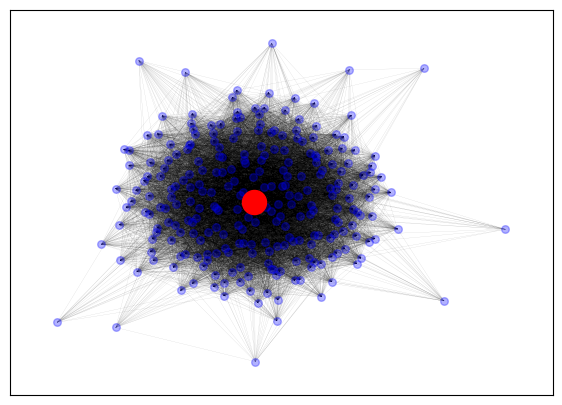

In [8]:
(large_500th_hub, degree) = sorted(node_and_degree, 
                                   key=itemgetter(1))[500]  #500
print('Largest Hub Node = {} with degree of {}'.format(large_500th_hub,
                                                       degree))

# Create ego graph of main hub
hub_ego=nx.ego_graph(G,large_500th_hub)

# Draw graph
plt.figure(figsize=(7,5))
pos = nx.spring_layout(hub_ego)
nx.draw_networkx(hub_ego, pos, node_color="b", node_size=30,
                 edge_color='black', alpha=0.3, width=0.1,
                 with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r", "label":
           str(large_500th_hub)}
nx.draw_networkx_nodes(hub_ego, pos, 
                       nodelist=[large_500th_hub], **options)

#plt.savefig('ego_graph.png')
plt.show()

This network shown above is an illustration of ego network of the node $96$ connected with $256$ other users, ranked in the 500th position in terms of its connected users. Its network macro structure resembles the largest ego network above. 

Smallest Hub Node = 780 with degree of 14


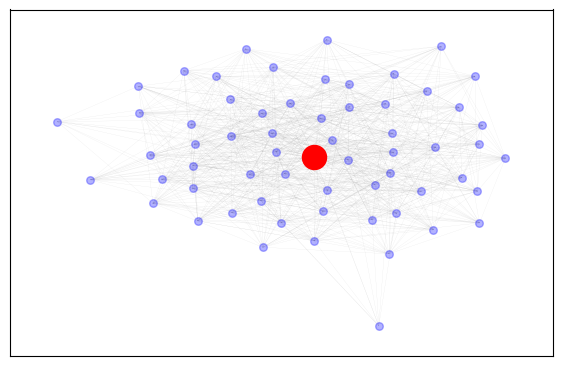

In [9]:
hub_node = 1
(nth_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[hub_node-1]
print('Smallest Hub Node = {} with degree of {}'.format(nth_hub, degree))
hub_ego=nx.ego_graph(G,hub_node)

# Draw graph
plt.figure(figsize=(7,4.5))
pos = nx.spring_layout(hub_ego)
nx.draw_networkx(hub_ego, pos, node_color="b", node_size=30,
                 edge_color='gray', alpha=0.3, width=0.1, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r", "label": "1"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[hub_node], **options)

#plt.savefig('ego_graph.png')
plt.show()

This network shown above is an illustration of ego network of the node $780$ connected with only $14$ other users, with least number of connected users.

These charts and networks seem interesting visually but do not provide quantifiable measures to help predict new links and connections to form at next time epoch. We will explore concepts and measures to quantify similarities between nodes, as a prep-step to building logistic regression model to address the link prediction problem.

### 2.3 Concepts and Measures to Predict New Links

Three attributes help explain why many link prediction methods tend to measure and compute proximity or “similarity” between each pair of nodes. 
  1. Potential New Links, or non-existent edges in current network 
  1. Each new link connects and involves a pair of nodes, and
  1. Empirically, nodes/people who share more connections in a network have a higher tendency to become connected, choosing to form a so-called triadic closure relation in the graph topology.
    
In this study, we will define and compute the following ten (10) similarity measures that can be used as a set of features for supervised learning:

 1. Common Neighbors (CNI) of node $u$ and $v$: CNI$(u,v)=| N(u) \cap N(v) |$ where $N$($u$) = the set of neighbors of node $u$.
 1. Jaccard’s coefficient (JCI) of node $u$ and $v$ normalizes CNI($u$, $v$): JCI$(u,v)=\frac{| N(u) \cap N(v) |}{| N(u) \cup N(v) |}.$
 1. Resource Allocation Index (RAI) of node $u$ and $v$ defines Fraction of a ”resource” that node $u$ can send to another node $v$ through their common neighbors: RAI($u$, $v$)=$\sum_{w \in N(u) \cap N(v)} \frac{1}{|N(w)|}$.
 1. Adamic-Adar Index (AAI) of node $u$ and $v$ is log-version of RAI($u$, $v$): AAI($u$, $v$)=$\sum_{w \in N(u) \cap N(v)} \frac{1}{log(|N(w)|)}$.
 1. Preferential Attachment Index (PAI) of node $u$ and $v$: PAI($u$, $v$)=$|N(u)| \times |N(v)|$, namely, nodes with high degree get more neighbors.
 1. Adjusted-Rand Index (ARI) of node $u$ and $v$: ARI$(u,v) = \frac{2(ad-bc)}{(a+b)(b+d)+(a+c)(c+d)}$. Literature were reviewed and summarized below in order to implement this measure.  
 1. Neighborhood Distance (NDI) of node $u$ and $v$: NDI$(u,v)=\frac{| N(u) \cap N(v) |}{\sqrt{| N(u)| \times |N(v)|}}.$
 1. Total Neighbors (TNI) of node $u$ and $v$: TNI$(u,v)=| N(u) \cup N(v) |$.
 1. Node degree (UDI) of node $u$: UDI$(u,v)=| N(u) |$.
 1. Node degree (VDI) of node $v$: VDI$(u,v)=| N(v) |$.
 
 References:
  1. _Link Prediction – Predict edges in a network using Networkx_, geeks-for-geeks.org, 
https://www.geeksforgeeks.org/link-prediction-predict-edges-in-a-network-using-networkx/.
  1. _link-prediction-how-to-predict-your-future-connections-on-facebook_, Prateek Joshi, 21 Apr, 2020, Analytics Vidhya, https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/.
 

#### 2.3.1 Computing Adjusted-Rand Index of node 𝑢 and 𝑣, ARI(𝑢,𝑣) 

To introduce general notation for a network, assume $n_i$ is the $i^{th}$ object, and $i = 1, \dots , N$. Frequently, network information is collected in the adjacency matrix, $A_{N×N} = \{ a_{ij} \}$, where $A$ is a square $N × N$ matrix that represents the connections between all pairs of objects. Specifically, $a_{ij} = 1$ if $n_i$ is connected to $n_j$; otherwise, $a_{ij} = 0$. This information can be summarized in row vectors corresponding to the $i^{th}$ and $j^{th}$ row in $A$, $a′_i$ and $a′_j$, (where each are $1 × n$ vectors, respectively).

If one considers the similarity between $n_i$ and $n_j$, there are four possible “states” for binary vectors that can be computed when considering the mutual pattern of connections between $n_i$ and $n_j$ when related to all of the other remaining nodes. The counts of these states gives us four quantities:   
 - $a$ = the number of links to other nodes $n_m$ that $n_i$ and $n_j$ have in common, 
 - $b$ = the number of times that $n_i$ has links to other nodes $n_m$, and $n_j$ does not, 
 - $c$ = the number of times that $n_i$ does not have links to other nodes $n_m$, but $n_j$ does, and
 - $d$ = the number of times that links to other nodes $n_m$ are mutually absent for $n_i$ and $n_j$.  

For any pair of row vectors, $a′_i$ and $a′_j$, in the adjacency matrix the four quantities can be quickly computed from the following inner products:

$a=a′_i a_j$, $b=a′_i(1−a_j)$, $c=(1−a_i)′a_j$, and $d=(1−a_i)′(1−a_j)$.  

Often, these four values are collected in a simple $2 × 2$ contingency table, as indicated in Table 1. The values of this contingency table are combined in various ways to form similarity or proximity measures. Four proximity measures currently used for link prediction studies are described in the next section, three of which are calculated from the proximity table.

Table 1: The contingency table for each pair of nodes $n_i$ and $n_j$ across all other nodes $n_m$.

|                        | Linked to Node $n_m$ | Not Linked to Node $n_m$ | 
|-----------------------:|:------------------:|:----------------------:| 
| Linked to Node $n_m$     | $a$              | $b$       |  
| Not Linked to Node $n_m$ | $c$              | $d$    |  


Reference: _A Note on Using the Adjusted Rand Index for Link Prediction in Networks_, Michaela Hoffman, Douglas Steinley, and Michael J. Brusco, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6191196/

### 2.4 Find Removable Links from Connected Node Pairs to Simulate Positive Samples
This step randomly drops some of the edges from the graph in a way to ensure that the reduced netowkr is still connected as one component, namely all the nodes are connected as one graph/component.

The dataset will be split into two parts to simulate the connections growing process from current connections state to next connections state with new connections formed in the community. As shown above, current community connections states comprise 80% of the active edges dataset. The 20% of the active edges dataset with known new connections will be used as positive target  examples to be used to train the logistic regression model with the other ten similarity measures.

Reference: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/. 

In [10]:
initial_node_count = len(G.nodes)
print(initial_node_count)

data_edges_temp = data_edges.copy(deep=True)  # active == 1
print("data_edges_temp = ", data_edges_temp.shape)
data_edges_temp.reset_index()
for i in range(20):
    data_curr=data_edges_temp.sample(frac=0.8, random_state=123)
    G_temp = nx.from_pandas_edgelist(data_curr, source='u',
                                     target='v', create_using=GraphType)
    print("len(G_temp.nodes) = ", len(G_temp.nodes))
    print("nx.number_connected_components(G_temp) = ",
          nx.number_connected_components(G_temp))
    if((nx.number_connected_components(G_temp)==1) and 
       (len(G_temp.nodes)==initial_node_count)):
        print("i = ", i)
        data_next = data_edges_temp.drop(data_curr.index)
        break

print(initial_node_count)
print("data_curr = ", data_curr.shape)
# These will be used as positive samples (namel, active==1)
print("data_next = ", data_next.shape)

1000
data_edges_temp =  (117031, 4)
len(G_temp.nodes) =  1000
nx.number_connected_components(G_temp) =  1
i =  0
1000
data_curr =  (93625, 4)
data_next =  (23406, 4)


### 2.5 Create Research Dataset to Simulate Community Connections Growing Process

As mentioned above, the 20% of the active edges dataset with known new connections will be used as positive target examples to be used to train the logistic regression model with the ten ($10$) similarity measures defined above. These actives edges will be merged with the non-connected edges identified from the network constructed from the 80% active-edges dataset. The merged dataset will served as the base dataframe to house the ten proximity measures to compute one by one in the third step: Analysis in Model Building and Training.

In [11]:
# These will serve as positive samples
data_next["active"] = 1

print("Data Columns: ", data_curr.columns.tolist())
print("# of Unique Vertices: ",data_curr["u"].value_counts().shape[0])
print("# of Unique Vertices: ",data_curr["v"].value_counts().shape[0])
data_curr_edges = data_curr[data_curr["active"]==1]
print("# of Unique Edges: ", data_curr_edges.shape[0])
print(data_next.head())

Data Columns:  ['edge_id', 'active', 'u', 'v']
# of Unique Vertices:  876
# of Unique Vertices:  998
# of Unique Edges:  93625
    edge_id  active    u    v
0         0       1  224  416
9         9       1  224  166
14       14       1  224  576
26       26       1  224  719
36       36       1  224  538


In [12]:
data_next["Conn"] = data_next.apply(
    lambda row: "(" + str(row.u) + ", " + str(row.v) + ")", axis=1)
data_next.set_index("Conn", inplace=True)

In [13]:
# Use edges in the list of data_curr_edges to
# simulate the company connections at current time t
G_Curr = nx.from_pandas_edgelist(data_curr_edges,
                                 source='u', target='v',
                                 create_using= nx.Graph())

# These non-connectioned edges will serve negative
# samples in the modeling dataset.
df = pd.DataFrame()
df = pd.DataFrame(index=nx.non_edges(G_Curr))
df.shape

(405875, 0)

In [14]:
# This step merge non-connected data (negative samples) with the
# removable connected edges to serve as positive/acitve samples.
df = pd.concat([df, data_next.drop(['edge_id','u', 'v', 'active'],
                                   axis=1)], axis=1)
df.shape

(429281, 0)

## 3. Analysis in Model Building and Training

### 3.1 Feature Engineering for Supervised Learning

### 3.2 Visualizing Features

### 3.3 Create Training and Testing Datasets

### 3.4 Logistic Regression Model Building and Training

### 3.1 Feature Engineering for Supervised Learning

Now we will use the similarity measures defined above to extract features from the network G in order to perform Supervised Learning in our binary classification predictive model. 

The following set of codes are to compute the following ten features that will be uded in our learning and prediction model: Common Neighbors Index (CNI), Jaccard Coefficient Index (JCI), Adamic-Adar Index (AAI), Resource Allocation Index (RAI), Preferential Attachement Index (PAI), Adjusted-Rand Index (ARI), Neighborhood Distance Index (NDI), Total Neighbors Index (TNI), and two Node Degree Indices (UDI and VDI).

In [15]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
       Incidence_matrix for a good explanation on edge matrices
    See https://www.learndatasci.com/tutorials/
                k-means-clustering-algorithms-python-intro/
          Transform graph into an adjacency matrix
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    for node in G:
        #print(node)
        edge_mat[node][node] = 1
        #print(list(G.neighbors(node)))
        # See https://stackoverflow.com/questions/
        #   52858137/set-numpy-array-values-through-list-comprehension
        edge_mat[np.c_[node],list(G.neighbors(node))] = 1

    return edge_mat

In [16]:
# edge_mat = graph_to_edge_matrix(G)
# edge_mat

In [17]:
def compute_adjusted_rand_index(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
      Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    edge_mat = graph_to_edge_matrix(G)
    # Initialize edge matrix with zeros
    data_AAI = np.zeros((len(G), len(G)), dtype=float)
    data_adj = np.array(edge_mat)

    for e in nx.non_edges(G):
        a = np.dot(data_adj[e[0]][:], data_adj[:][e[1]])
        b = np.dot(data_adj[e[0]][:], 
                   np.ones(len(G))-data_adj[:][e[1]])
        c = np.dot(np.transpose(np.ones(len(G)))-
                   data_adj[e[0]][:], data_adj[:][e[1]])
        d = np.dot(np.transpose(np.ones(len(G)))-
                   data_adj[e[0]][:], 
                   np.ones(len(G))-data_adj[:][e[1]])
        
        data_AAI[e[0]][e[1]] = (2*(a*d-b*c))/((a+b)*(b+d)+(a+c)*(c+d))

    return data_AAI

#compute_adjusted_rand_index(G)

In [18]:
def compute_Neighbor_Distance_index(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
    Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    data_NDI = np.zeros((len(G), len(G)), dtype=float)

    for e in nx.non_edges(G):
        a = G.degree(e[0])
        b = G.degree(e[1])
        c = len(list(nx.common_neighbors(G, e[0], e[1])))
        data_NDI[e[0]][e[1]] = c/math.sqrt(a*b)

    return data_NDI

#compute_Neighbor_Distance_index(G)

In [19]:
def compute_Total_Neighbors_index(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
    Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    data_TNI = np.zeros((len(G), len(G)), dtype=int)
    
    for e in nx.non_edges(G):
        edges1 = set(G.edges(e[0]))
        edges2 = set(G.edges(e[1]))
        c = len(edges1.union(edges2))
        data_TNI[e[0]][e[1]] = c

    return data_TNI

#compute_Total_Neighbors_index(G)

In [20]:
def compute_Node_Degree_index(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
    Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    data_NDI = np.zeros(len(G), dtype=int)

    for e in nx.non_edges(G):
        data_NDI[e[0]] = G.degree(e[0])

    return data_NDI

#compute_Node_Degree_index(G)

In [21]:
def compute_Vertex_Degree_index(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/
    Incidence_matrix for a good explanation on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    data_VDI = np.zeros(len(G), dtype=int)
    # Initialize edge matrix with zeros
    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for e in nx.non_edges(G):
        data_VDI[e[1]] = G.degree(e[1])

    return data_VDI

#compute_Vertex_Degree_index(G)

In [22]:
# Common Neighbors
df['CNI'] = None
SMI = [((e[0], e[1]), 
        len(list(nx.common_neighbors(G_Curr, e[0], e[1]))))
       for e in nx.non_edges(G_Curr)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'CNI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done with Common Neighbors Index")

# Jaccard Coefficient - Normalized Common Neighbors
df['JCI'] = None
SMI = [((e[0], e[1]), 
        list(nx.jaccard_coefficient(G_Curr, [(e[0], e[1])]))[0][2])
       for e in nx.non_edges(G_Curr)]

df2 = pd.DataFrame(SMI, columns=['Conn', 'JCI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Jaccard Coefficient - Normalized CNI")

# Resource Allocation Index
df['RAI'] = None
SMI = [((e[0], e[1]),
        list(nx.resource_allocation_index(G_Curr,
                                          [(e[0], e[1])]))[0][2])
       for e in nx.non_edges(G_Curr)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'RAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Resource Allocation Index")

# Adamic-Adar Index, log-version of RAI
df['AAI'] = None
SMI = [((e[0], e[1]), 
        list(nx.adamic_adar_index(G_Curr, 
                                  [(e[0], e[1])]))[0][2])
       for e in nx.non_edges(G_Curr)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'AAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Adamic-Adar Index, log-version of RAI Index")

# Preferentail Attachment - Product of the nodes' degree
df['PAI'] = None
SMI = [((e[0], e[1]), 
        list(nx.preferential_attachment(G_Curr,
                                        [(e[0], e[1])]))[0][2])
       for e in nx.non_edges(G_Curr)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'PAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Preferentail Attachment Index")

# Adjusted-Rand Index
df['ARI'] = None
data_SMI = compute_adjusted_rand_index(G_Curr)
SMI = []
for e in nx.non_edges(G_Curr):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'ARI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Adjusted-Rand Index")

# Neighborhood Distance Index
df['NDI'] = None
data_SMI = compute_Neighbor_Distance_index(G_Curr)
SMI = []
for e in nx.non_edges(G_Curr):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'NDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Neighborhood Distance Index")

# Total Neighbors Index
df['TNI'] = None
data_SMI = compute_Total_Neighbors_index(G_Curr)
SMI = []
for e in nx.non_edges(G_Curr):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'TNI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Total Neighbors Index")

# Node U Neighbors
df['UDI'] = None
data_SMI = compute_Node_Degree_index(G_Curr)
SMI = []
for e in nx.non_edges(G_Curr):
    SMI.append(((e[0], e[1]), data_SMI[e[0]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'UDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Node U Neighbors Index")

# Node V Neighbors
df['VDI'] = None
data_SMI = compute_Vertex_Degree_index(G_Curr)
SMI = []
for e in nx.non_edges(G_Curr):
    SMI.append(((e[0], e[1]), data_SMI[e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'VDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)
print("Done Node V Neighbors Index")

Done with Common Neighbors Index
Done with Jaccard Coefficient - Normalized Common Neighbors Index
Done Resource Allocation Index
Done Adamic-Adar Index, log-version of RAI Index
Done Preferentail Attachment Index
Done Adjusted-Rand Index
Done Neighborhood Distance Index
Done Total Neighbors Index
Done Node U Neighbors Index
Done Node V Neighbors Index


In [23]:
# Check Results
print(df.shape)
df.head()

(429281, 10)


,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,UDI,VDI
"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0
"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.1473,231.0,61.0,170.0
"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0
"(0, 4)",16.0,0.080402,0.05863,2.847288,9394.0,0.064617,0.16508,215.0,61.0,154.0
"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0


In [24]:
# Save the results as a csv file to save the time of running another time.
currDir = os.getcwd()
final_path = os.path.join(currDir, 
                          'curr_edges_similarity_features_kaggle.csv')
df.to_csv(final_path)

In [25]:
# Read the saved CSV file back
df = pd.read_csv('curr_edges_similarity_features_kaggle.csv')
df.columns = ['Conn','CNI','JCI','RAI','AAI',
              'PAI','ARI','NDI','TNI','VDI','UDI']

#df.set_index('Conn', inplace=True)
print(df.shape)
df.head()

(429281, 11)


,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI
0,"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0
1,"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.147300,231.0,61.0,170.0
2,"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0
3,"(0, 4)",16.0,0.080402,0.058630,2.847288,9394.0,0.064617,0.165080,215.0,61.0,154.0
4,"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0


In [26]:
# This is to recover node u and v from the Index Conn 
def define_u_node(conn_edge):
    conn_edge_nodes = conn_edge.strip("()")
    nodes_list = conn_edge_nodes.partition(',')
    #print(nodes_list)
    # Strip spaces first before making it as integer
    return(int(nodes_list[0].strip()))

def define_v_node(conn_edge):
    conn_edge_nodes = conn_edge.strip("()")
    nodes_list = conn_edge_nodes.partition(',')
    # Strip spaces first before making it as integer
    return(int(nodes_list[-1].strip()))

# df=df.reset_index()
# Apply the function to the Age column using the apply() function
df['u'] = df['Conn'].apply(define_u_node)
df['v'] = df['Conn'].apply(define_v_node)

In [27]:
df.head()

,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,u,v
0,"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0,0,1
1,"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.147300,231.0,61.0,170.0,0,2
2,"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0,0,3
3,"(0, 4)",16.0,0.080402,0.058630,2.847288,9394.0,0.064617,0.165080,215.0,61.0,154.0,0,4
4,"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0,0,6


In [28]:
# Drop column edge_id
data_next.drop(['edge_id'], inplace=True, axis=1)
data_next.head()

,active,u,v
Conn,,,
"(224, 416)",1,224,416
"(224, 166)",1,224,166
"(224, 576)",1,224,576
"(224, 719)",1,224,719
"(224, 538)",1,224,538


In [29]:
data_next.reset_index(drop=True)
df = df.merge(data_next, how='left', on=["u","v"])
df = df.fillna(0)
df.head()

,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,u,v,active
0,"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0,0,1,0.0
1,"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.147300,231.0,61.0,170.0,0,2,0.0
2,"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0,0,3,0.0
3,"(0, 4)",16.0,0.080402,0.058630,2.847288,9394.0,0.064617,0.165080,215.0,61.0,154.0,0,4,0.0
4,"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0,0,6,0.0


In [30]:
df.shape

(429281, 14)

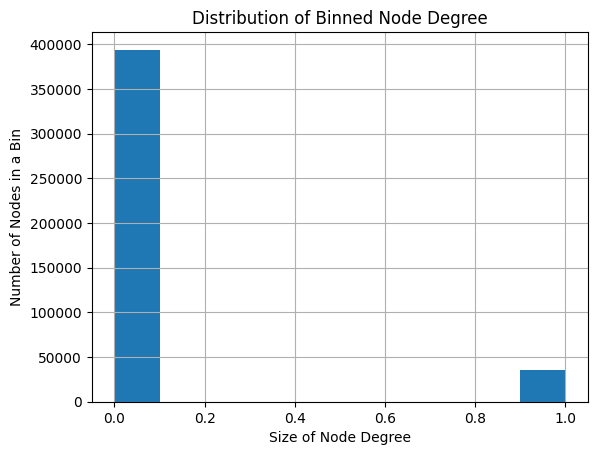

In [31]:
pd.DataFrame(df['active']).hist(bins=10)
# Add title and axis names
plt.title('Distribution of Binned Node Degree')
plt.xlabel('Size of Node Degree')
plt.ylabel('Number of Nodes in a Bin')
pyplot.show()

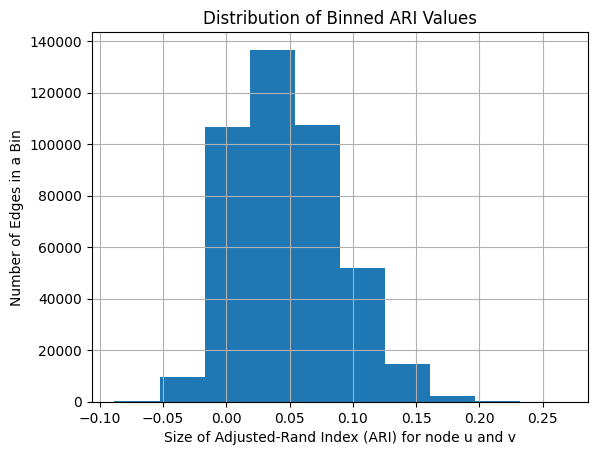

In [32]:
data_ari = df[df['active']>=0]['ARI']
#print(node_sizes)
pd.DataFrame(data_ari).hist(bins=10)
# Add title and axis names
plt.title('Distribution of Binned ARI Values')
plt.xlabel('Size of Adjusted-Rand Index (ARI) for node u and v')
plt.ylabel('Number of Edges in a Bin')
pyplot.show()

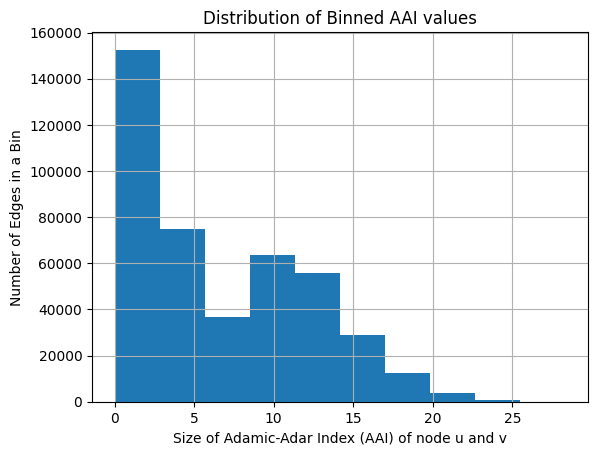

In [33]:
data_aai = df[df['active']>=0]['AAI']  # log-version of RAI(u, v)
pd.DataFrame(data_aai).hist(bins=10)
# Add title and axis names
plt.title('Distribution of Binned AAI values')
plt.xlabel('Size of Adamic-Adar Index (AAI) of node u and v')
plt.ylabel('Number of Edges in a Bin')
pyplot.show()

In [34]:
# Source: https://dfrieds.com/machine-learning/
# visual-introduction-classification-logistic-regression-python.html
sns.set_context("talk")
sns.set_style("whitegrid", {'grid.color': '.92'})

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) 
     such as 4500 into 4.5K and also appropriately turns 4000 into 4K
     (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values
    # such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + 
                              new_tick_format[index_of_decimal+2:]

    return new_tick_format

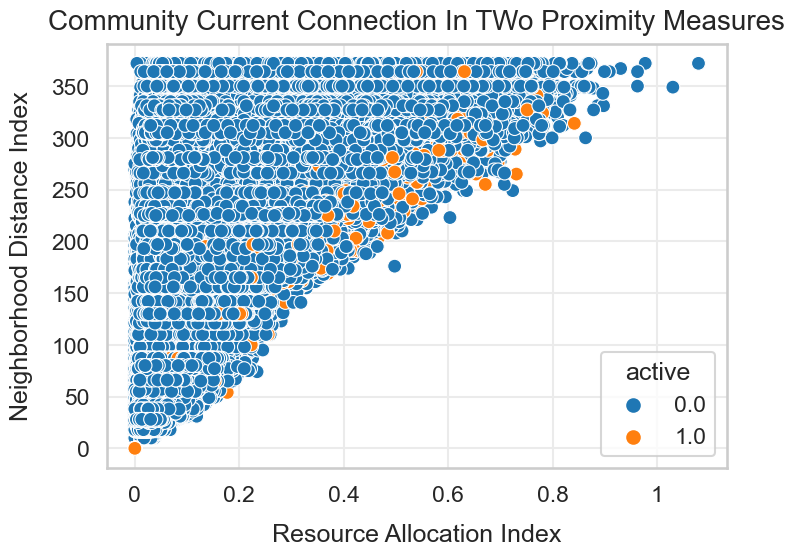

In [35]:
plt.figure(figsize=(8, 5.5))
sns.scatterplot(x='RAI', y='UDI', hue='active', data=df, s=100)
plt.title("Community Current Connection In TWo Proximity Measures",
          y=1.015, fontsize=20)
plt.xlabel("Resource Allocation Index", labelpad=13)
plt.ylabel("Neighborhood Distance Index", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [36]:
df.reset_index()
df.head()

,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,u,v,active
0,"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0,0,1,0.0
1,"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.147300,231.0,61.0,170.0,0,2,0.0
2,"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0,0,3,0.0
3,"(0, 4)",16.0,0.080402,0.058630,2.847288,9394.0,0.064617,0.165080,215.0,61.0,154.0,0,4,0.0
4,"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0,0,6,0.0


In [37]:
# The 70% and 30% breaks of the dataset will be used to train and test
# the logistic regression model and lightGBM model.

X = df.iloc[:,1:11]
y = df.iloc[:,13].astype('category') #int')
print('X Size = {},  y size = {}'.format(X.shape, y.shape[0]))

# There will be 30% of the dataset will be held to test and
# evaluate the performance
# of the trained model for link predictions.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=35)
print('X_train Size = {},  y_train size = {}'.format(X_train.shape,
                                                     y_train.shape[0]))
print('X_test Size = {},  y_test size = {}'.format(X_test.shape,
                                                   y_test.shape[0]))
print(sum(y_train))

X Size = (429281, 10),  y size = 429281
X_train Size = (300496, 10),  y_train size = 300496
X_test Size = (128785, 10),  y_test size = 128785
24644.0


In [38]:
print('Connectioned Status Mean in Train dataset = {}%'
      .format(round(100*sum(y_train)/len(y_train),1)))
print('Connectioned Status Mean in Test dataset = {}%'
      .format(round(100*sum(y_test)/len(y_test),1)))

Connectioned Status Mean in Train dataset = 8.2%
Connectioned Status Mean in Test dataset = 8.3%


In [39]:
lr = LogisticRegression(C=1, class_weight="balanced")
lr_model = lr.fit(X_train, y_train)
print("Intercept = ", lr_model.intercept_)
print(lr_model.coef_.round(4))

Intercept =  [0.00037206]
[[-0.0003 -0.     -0.     -0.0001  0.0001 -0.     -0.     -0.0103  0.0057
  -0.016 ]]


#### Plot to Examine and Compare Effect of Proximity Measures to Predict Future Connection

A random forest classifier will be fitted to compute the feature importances. Feature importances are computed based on mean decrease in impurity and feature permutation.

It is clearly that the UDI measure has much greater contributions to help predict future connections than other proximity measures. RAI measure has moderate contribution as well to help predict future connections.

Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

In [40]:
from sklearn.ensemble import RandomForestClassifier
import time

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ 
              for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.026 seconds


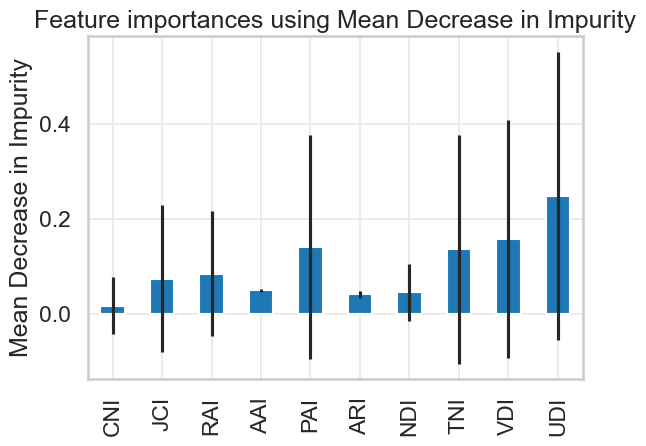

In [41]:
feature_names = [f"{feature}" for feature in X_train.columns.tolist()]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

In [42]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 73.160 seconds


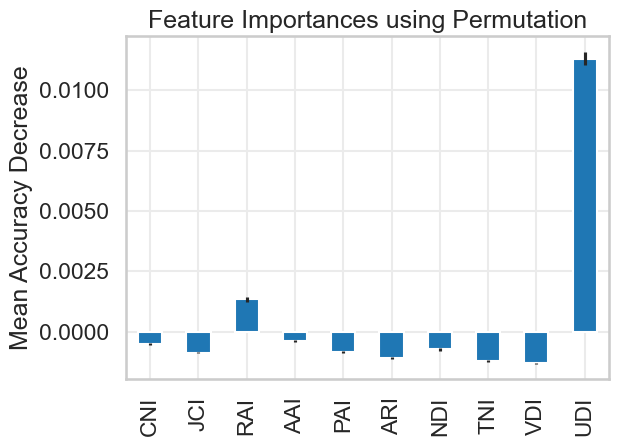

In [43]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances using Permutation")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

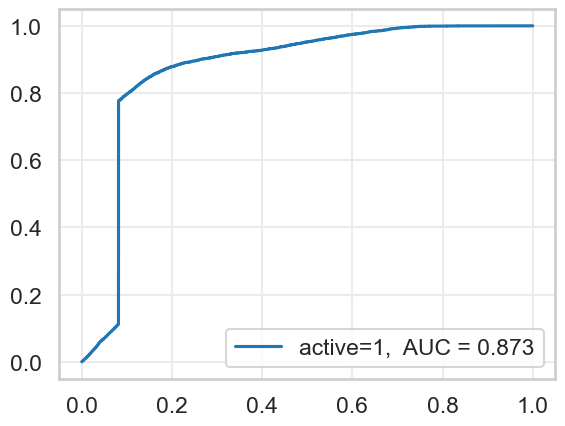

In [44]:
y_pred_proba = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="active=1,  AUC = "+str(round(auc,3)))
plt.legend(loc=4)
plt.show()

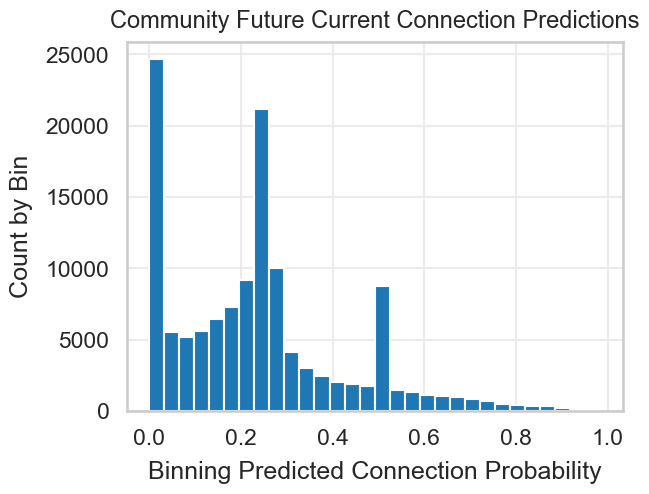

In [45]:
y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba
y_pred_proba.columns = ['Link_Pred_Prob']
plt.hist(y_pred_proba['Link_Pred_Prob'], bins=30)
plt.title("Community Future Current Connection Predictions",
          y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)

pyplot.show()

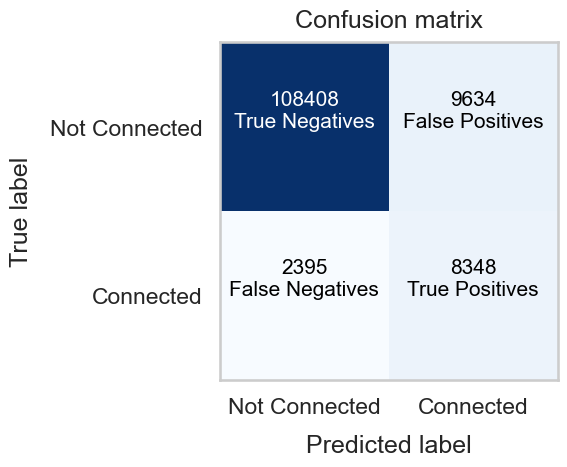

In [46]:
#Source: https://dfrieds.com/machine-learning/
# visual-introduction-classification-logistic-regression-python.html
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]),
                                  range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name,
                 horizontalalignment="center", 
                 fontsize=15, color="white" 
                 if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=12)
    plt.xlabel('Predicted label', labelpad=12)
    plt.title(title, y=1.02)
    plt.tight_layout()

# make class predictions for the testing set
y_pred_class = lr_model.predict(X_test)

class_names = ["Not Connected", "Connected"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [47]:
# Calculate model performances in accuracy, 
# precision, f1 score and roc auc measures
print("Accuracy Score = ", 
      round(metrics.accuracy_score(y_test,
                                   y_pred_class)*100,1),
      "%")
print("Precision Score = ", 
      round(metrics.precision_score(y_test,
                                    y_pred_class)*100, 1), "%")
print("F1 Score = ", 
      round(metrics.f1_score(y_test, y_pred_class)*100,1), "%")
print("roc auc Score = ", 
      round(metrics.roc_auc_score(y_test, y_pred_class), 3))

Accuracy Score =  90.7 %
Precision Score =  46.4 %
F1 Score =  58.1 %
roc auc Score =  0.848


#### Balanced Dataset

In [48]:
print('Connectioned Status Mean in df dataset = {}%'
      .format(round(100*sum(df["active"])/df.shape[0],1)))
df.head()

Connectioned Status Mean in df dataset = 8.2%


,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,u,v,active
0,"(0, 1)",7.0,0.067961,0.023691,1.228586,2989.0,0.073724,0.128037,110.0,61.0,49.0,0,1,0.0
1,"(0, 2)",15.0,0.069444,0.051098,2.637283,10370.0,0.041531,0.147300,231.0,61.0,170.0,0,2,0.0
2,"(0, 3)",7.0,0.072165,0.023885,1.230655,2623.0,0.084978,0.136678,104.0,61.0,43.0,0,3,0.0
3,"(0, 4)",16.0,0.080402,0.058630,2.847288,9394.0,0.064617,0.165080,215.0,61.0,154.0,0,4,0.0
4,"(0, 6)",14.0,0.063927,0.052342,2.499619,10492.0,0.030663,0.136678,233.0,61.0,172.0,0,6,0.0


In [49]:
print(df.columns)
#train = df[df['active']>=0]
#print(train.columns)
data = df.drop(['Conn','u','v'],axis=1)  # Drop three columns
data_active = data[data['active']==1]
data_nonactive = data[data['active']==0].sample(
    frac=0.085, random_state=123)
data_active.shape[0]/(data_active.shape[0]+data_nonactive.shape[0])
data_balanced = pd.concat([data_active, data_nonactive])

Index(['Conn', 'CNI', 'JCI', 'RAI', 'AAI', 'PAI', 'ARI', 'NDI', 'TNI', 'VDI',
       'UDI', 'u', 'v', 'active'],
      dtype='object')


In [50]:
data_balanced.head()

,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,active
3679,47.0,0.165493,0.181522,8.442333,27258.0,0.139731,0.284676,331.0,154.0,177.0,1.0
3761,41.0,0.129747,0.158156,7.360168,31262.0,0.063430,0.231887,357.0,154.0,203.0,1.0
3953,46.0,0.154882,0.175915,8.248642,29106.0,0.115694,0.269629,343.0,154.0,189.0,1.0
4254,29.0,0.109023,0.105965,5.159746,21714.0,0.055261,0.196801,295.0,154.0,141.0,1.0
4287,41.0,0.128931,0.166576,7.428436,31570.0,0.061049,0.230753,359.0,154.0,205.0,1.0


In [51]:
# The step produces 50% vs. 50% of the balanced
# dataset in terms of active vs. non-active links
# that will be used to train and test the 
# logistic regression model and lightGBM model.

X = data_balanced.iloc[:,0:10]
y = data_balanced.iloc[:,10].astype('category')
print('X Size = {},  y size = {}'.format(X.shape, y.shape[0]))

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y,
                                                            test_size=0.3,
                                                            random_state=8)
print('X_train Size = {},  y_train size = {}'.format(X_train_b.shape,
                                                     y_train_b.shape[0]))
print('X_test Size = {},  y_test size = {}'.format(X_test_b.shape,
                                                   y_test_b.shape[0]))

X Size = (68868, 10),  y size = 68868
X_train Size = (48207, 10),  y_train size = 48207
X_test Size = (20661, 10),  y_test size = 20661


In [52]:
lr_model_balance = LogisticRegression(C=1).fit(X_train_b, y_train_b)

C:\Users\alexz\anaconda3\envs\arnids-aide\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


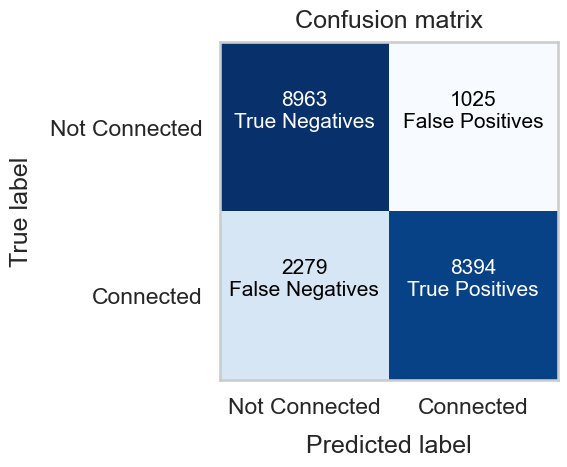

In [53]:
# make class predictions for the testing set
y_pred_class_b = lr_model_balance.predict(X_test_b)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_b, y_pred_class_b);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')

In [54]:
# calculate model performances in accuracy, precision, f1-score, and roc auc metrics
print("Accuracy Score = ", 
      round(metrics.accuracy_score(y_test_b, 
                                   y_pred_class_b)*100,1), "%")
print("Precision Score = ", 
      round(metrics.precision_score(y_test_b, 
                                    y_pred_class_b)*100, 1), "%")
print("F1 Score = ", 
      round(metrics.f1_score(y_test_b, 
                             y_pred_class_b)*100,1), "%")
print("roc auc Score = ", 
      round(metrics.roc_auc_score(y_test_b, 
                                  y_pred_class_b), 3))

Accuracy Score =  84.0 %
Precision Score =  89.1 %
F1 Score =  83.6 %
roc auc Score =  0.842


In [55]:
# reference: https://www.geeksforgeeks.org/lightgbm-model-evaluation-metrics/
import lightgbm as lgbm

X = df.iloc[:,1:11]
y = df.iloc[:,13].astype('int')
print('X Size = {},  y size = {}'.format(X.shape, y.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=35)
print('X_train Size = {},  y_train size = {}'.format(X_train.shape,
                                                     y_train.shape[0]))
print('X_test Size = {},  y_test size = {}'.format(X_test.shape,
                                                   y_test.shape[0]))

train_data = lgbm.Dataset(X_train, y_train)
test_data = lgbm.Dataset(X_test, y_test)

# define parameters
parameters = {
    'objective': 'binary', 'metric': 'auc',
    'is_unbalance': 'true', 'feature_fraction': 0.5,
    'bagging_fraction': 0.5, 'bagging_freq': 20,
    'num_threads' : 2, 'seed' : 76
}

# train lightGBM model
lgbm_model = lgbm.train(parameters, train_data,
                        valid_sets=test_data,
                        num_boost_round=1000)

X Size = (429281, 10),  y size = 429281
X_train Size = (300496, 10),  y_train size = 300496
X_test Size = (128785, 10),  y_test size = 128785
[LightGBM] [Info] Number of positive: 24644, number of negative: 275852
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 300496, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082011 -> initscore=-2.415331
[LightGBM] [Info] Start training from score -2.415331
[1]	valid_0's auc: 0.941086
[2]	valid_0's auc: 0.943641
[3]	valid_0's auc: 0.944005
[4]	valid_0's auc: 0.944603
[5]	valid_0's auc: 0.944774
[6]	valid_0's auc: 0.944724
[7]	valid_0's auc: 0.944935
[8]	valid_0's auc: 0.945074
[9]	valid_0's auc: 0.945015
[10]	valid_0's auc: 0.944896
[11]	valid_0's auc: 0.945043
[12]	valid_0's auc: 0.945111
[13]	valid_0's auc: 

In [56]:
# calculate model performances in accuracy, 
# precision, f1-score, and roc auc metrics
# make class predictions for the testing set
y_pred_lgbm = lgbm_model.predict(X_test)

print("Accuracy Score = ",
      round(metrics.accuracy_score(y_test,
                                   (y_pred_lgbm > 0.5).astype(int))*100,1), "%")
print("Precision Score = ", 
      round(metrics.precision_score(y_test, 
                                    (y_pred_lgbm > 0.5).astype(int))*100, 1), "%")
print("F1 Score = ", 
      round(metrics.f1_score(y_test, 
                             (y_pred_lgbm > 0.5).astype(int))*100,1), "%")
print("roc auc Score = ",
      round(metrics.roc_auc_score(y_test, y_pred_lgbm), 3))

Accuracy Score =  86.3 %
Precision Score =  36.1 %
F1 Score =  50.4 %
roc auc Score =  0.929


In [58]:
X = data_balanced.iloc[:,0:10]
y = data_balanced.iloc[:,10].astype('int')
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y,
                                                            test_size=0.3,
                                                            random_state=35)

train_data = lgbm.Dataset(X_train_b, y_train_b)
test_data = lgbm.Dataset(X_test_b, y_test_b)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model_balance = lgbm.train(parameters, train_data, 
                           valid_sets=test_data, 
                           num_boost_round=1000)

[LightGBM] [Info] Number of positive: 24795, number of negative: 23412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2395
[LightGBM] [Info] Number of data points in the train set: 48207, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514344 -> initscore=0.057393
[LightGBM] [Info] Start training from score 0.057393
[1]	valid_0's auc: 0.939741
[2]	valid_0's auc: 0.943333
[3]	valid_0's auc: 0.943127
[4]	valid_0's auc: 0.943716
[5]	valid_0's auc: 0.944005
[6]	valid_0's auc: 0.943494
[7]	valid_0's auc: 0.943894
[8]	valid_0's auc: 0.944247
[9]	valid_0's auc: 0.943721
[10]	valid_0's auc: 0.943185
[11]	valid_0's auc: 0.943604
[12]	valid_0's auc: 0.94392
[13]	valid_0's auc: 0.944094
[14]	valid_0's auc: 0.944257
[15]	valid_0's auc: 0.94444
[16]	valid_0's auc: 0.944521
[17]	valid_0's auc: 0.944668
[18]	valid_0's auc: 0.9

In [59]:
# calculate model performances in accuracy, precision, f1-score, and roc auc metrics
# make class predictions for the testing set
y_pred_lgbm_b = model_balance.predict(X_test_b)

# Calculate accuracy and ROC AUC score
print("Accuracy Score = ", 
      round(metrics.accuracy_score(y_test_b,
                                   (y_pred_lgbm_b > 0.5).astype(int))*100,1),
      "%")
print("Precision Score = ", 
      round(metrics.precision_score(y_test_b,
                                    (y_pred_lgbm_b > 0.5).astype(int))*100, 1),
      "%")
print("F1 Score = ", 
      round(metrics.f1_score(y_test_b,
                             (y_pred_lgbm_b > 0.5).astype(int))*100,1), "%")
print("roc auc Score = ", 
      round(metrics.roc_auc_score(y_test_b, y_pred_lgbm_b), 3))

Accuracy Score =  84.4 %
Precision Score =  86.6 %
F1 Score =  84.4 %
roc auc Score =  0.937


## Summary over Models Performances 

Two models of Logistic regression classification model and LightGBM were developed and fitted to solve link prediction problem using the unbalanced and balanced research datasets. Confusion Matrices and their derived Metrics of Accuracy, Precision, F1-Score, and ROC AUC ratio were computed to evaluate the performances of models fitted in different scenarios. As shown in Table 2 in the Winner column with the $\star$ sign, the finding is that the models fitted with balanced dataset give robust, consistent, and better predictive performances in all four metrics evaluated.

Table 2: Comparing Model Performances with Unbalanced and Balanced Datasets

|                        | Dataset    | Accuracy | Precision |$f_1$ Score | ROC AUC | Winner |
|-----------------------:|:----------:|:--------:|:---------:|:----------:|:-------:|:------:| 
| Logistic Regression    | Unbalanced | $91\%$    |  $46\%$    | $58\%$      | $0.848$ |        | 
| Regression             | Balanced   |$84\%$     | $89\%$     | $84\%$      | $0.842$ |  $\star$ |
| LightGBM (metric='auc') | Unbalanced |$86\%$    | $36\%$     | $50\%$      | $0.929$ |          |
| (metric='auc')          | Balanced  |$84\%$      | $86\%$     | $84\%$      | $0.937$ |  $\star$ |
  

### Discussing Challenging Issues

 - Due to the resulting **computational burden**, test set sampling is common in link prediction evaluation. For such sampling, the challenge task is that, if it is not properly reflective of the original distribution, can greatly increase the likelihood of biased evaluations that do not meaningfully indicate the true performance of link predictors.
 
 - The selected **evaluation metric** can have a tremendous bearing on the apparent quality and ranking of predictors even with proper testing distributions. 
 
 - The **directionality of links** also introduces challenge issues that do not exist in typical classification tasks.
 
 - For tasks involving **network evolution**, such as predicting the appearance of links in the future, the classification process involves temporal aspects.
 
 - Apply node2Vec algorithm to generate features (https://medium.com/aimonks/unveiling-the-power-of-graph-embeddings-a-comprehensive-exploration-of-node2vec-f9c54804e17b)

### Other References

 1. Xu-Wen Wang, Yize Chen, and Yang-Yu Liu, Link Prediction through Deep Learning, The Preprint Server for Biology, https://doi.org/10.1101/247577
 1. Anil A, Kumar D, Sharma S, Singha R, Sarmah R, Bhattacharya N, Singh S R, Link Prediction using Social Network Analysis over Heterogeneous Terrorist Network, 2015 IEEE Inter. Conf. on Smart City/SocialCom/SustainCom/DataCom 2015 and SC2 2015.
 1. Yang Y, Lichtenwalter R, and Chawla N, “Evaluating Link Prediction Methods”, arXiv.org, Cornell University.
 1. Daniel Romero, Applied Social Network Analysis in Python Course on Coursera
 1. J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.
 1. Jason Brownlee, How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
 1. Precision-Recall, https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
 1. Raf Guns, Link prediction with the linkpred tool, Measuring scholarly impact: Methods and practice 
 1. M. Hasan, V. Chaoji, S. Salem, and M. Zaki, Link Prediction using Supervised Learning.
 1. B. Chroł, M.Bojanowski, Proximity-based Methods for Link Prediction, https://cran.r-project.org/web/packages/linkprediction/vignettes/proxfun.html 
 1. Logistic Regression in Machine Learning, https://www.javatpoint.com/logistic-regression-in-machine-learning
 1. Guillaume Le Floch, Link Prediction In Large-Scale Networks, https://hackernoon.com/link-prediction-in-large-scale-networks-f836fcb05c88
 1. Link Prediction UTS, https://www.kaggle.com/c/link-prediction-uts/overview
 1. A Guide to Link Prediction – How to Predict your Future Connections on Facebook, https://www.kaggle.com/c/link-prediction-uts/overview
 1. Logistic Regression – A Complete Tutorial With Examples in R, https://www.machinelearningplus.com/machine-learning/logistic-regression-tutorial-examples-r/